In [2]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import networkx as nx
from factor_analyzer import FactorAnalyzer
import sys
from time import time
from sklearn.manifold import MDS
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import numpy as np


# Importing the Endnote library

In [21]:
def parse_ris_file(filename):
    records = []
    current_record = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('AU  -'):  # Author
                if 'First Author' not in current_record:
                    current_record['First Author'] = line[6:].strip()
            elif line.startswith('PY  -'):  # Publication Year
                current_record['Year'] = line[6:].strip().split('/')[0]  # Assuming format 'YYYY/MM/DD/'
            elif line.startswith('AB  -'):  # Abstract
                current_record['Abstract'] = line[6:].strip()
            elif line.startswith('DO  -'):  # DOI
                current_record['DOI'] = line[6:].strip()
            elif line == 'ER  -':  # End of record
                records.append(current_record)
                current_record = {}

    return pd.DataFrame(records)

# Replace 'path_to_your_ris_file.ris' with the path to your RIS file
df = parse_ris_file('velophary_endnote_library.txt')


In [22]:
t0 = time()

responses = []

for doi in df["DOI"]:
    if pd.notna(doi):
        api_call = f"https://opencitations.net/api/v1/metadata/{doi}"
        http_headers = {"authorization": "739eea95-2ca0-47b1-a11a-84028da7c324"}
        response = requests.get(api_call, headers=http_headers)
        if response.status_code == 200:
            responses.append(response.json())
        else:
            responses.append(None)
    else:
        responses.append(None)

print(f"Done in {time()-t0} seconds.")


Done in 61.46930289268494 seconds.


In [44]:
def element_to_df(element):
    if element is None:
        return pd.DataFrame([{'key1': None, 'key2': None}])
    else:
        return pd.DataFrame(element)

# Apply the function to each element and concatenate the results
primary_papers = pd.concat([element_to_df(element) for element in responses], ignore_index=True)

primary_papers["author"] = primary_papers["author"].str.split().str[0].str.rstrip(',') + " et al."
primary_papers['year'] = pd.to_datetime(primary_papers['year'], errors='coerce')
primary_papers['year'] = primary_papers['year'].dt.year
primary_papers['Primary or Secondary'] = 'Primary'
primary_papers.drop(columns=["key1", "key2", "source_title", "source_id", "volume", "page", "issue", "oa_link"], inplace=True)
primary_papers.to_excel("primary_papers_raw.xlsx")

In [45]:
primary_papers = pd.read_excel("primary_papers.xlsx")
primary_papers

Unnamed: 0                                              title  \
0            1  Prosthetic Management Of Postsurgical Soft Pal...   
1            2           Speech Prosthesis Versus Pharyngeal Flap   
2            3  Prosthetic Treatment For Speech Disorders Due ...   
3            4  Team Acceptance Of Specific Recommendations Fo...   
4            5  Dental Implants To Rehabilitate A Patient With...   
..         ...                                                ...   
59          60  Alternative Successful Functional Recovery Of ...   
60          61  Quality Of Life In Patients With Soft Palate R...   
61          62  Speech-aid Prosthesis In Velopharyngeal Incomp...   
62          63  Evaluation Of A Palatal Lift Prosthesis With A...   
63          64  Role Of Speech Aid Prosthesis As Diagnostic An...   

               author                                          reference  \
0      Aramany et al.  10.1016/0022-3913(52)90019-x; 10.1016/0022-391...   
1        Marsh et al.                                                NaN   
2      Yoshida et al.  10.1016/0022-3913(72)90198-9; 10.1016/s0022-39...   
3   Dixon-Wood et al.  6948632; 6994933; 10.1016/s0094-1298(20)31649-...   
4     Harrison et al.  10.1016/0278-2391(84)90008-9; 10.1016/s0300-97...   
..                ...                                                ...   
59      Tezuka et al.  10.1097/00006534-197102000-00010; 10.1001/arch...   
60  Artopoulou et al.  10.1007/s00520-011-1105-0; 10.1002/(sici)1097-...   
61        Kang et al.  477587; 10.1055/s-0031-1277711; 10.1016/j.coms...   
62      Nomoto et al.  10.1007/s00455-019-10023-y; 10.1152/ajpgi.1989...   
63       Wadud et al.  10.1097/00000637-200301000-00003; 10.1097/0000...   

                                             citation  citation_count  year  \
0   10.1016/0022-3913(78)90013-6; 10.1016/s0022-39...               6  1970   
1   10.1002/9781118785065.ch5; 10.1597/1545-1569(2...              43  1980   
2   10.1046/j.1365-2842.1998.00238.x; 10.1590/s167...              26  1990   
3   19128598; 10.1097/00020840-200312000-00008; 10...              14  1991   
4   10.3390/prosthesis3040034; 10.4103/ccd.ccd_193...              23  1992   
..                                                ...             ...   ...   
59                                                NaN               0  2020   
60                 10.1016/j.oraloncology.2022.105980               1  2021   
61  10.1016/j.prosdent.2022.11.022; 10.3390/prosth...               2  2021   
62   10.1007/s40141-023-00388-5; 10.2490/prm.20230006               2  2021   
63                                                NaN               0  2021   

                                                doi Primary or Secondary  
0                      10.1016/0022-3913(70)90027-2              Primary  
1                  10.1097/00006534-198005000-00009              Primary  
2                10.1111/j.1365-2842.1990.tb01427.x              Primary  
3   10.1597/1545-1569_1991_028_0285_taosrf_2.3.co_2              Primary  
4   10.1597/1545-1569_1992_029_0485_ditrap_2.3.co_2              Primary  
..                                              ...                  ...  
59                      10.1016/j.ajoms.2020.07.010              Primary  
60                   10.1016/j.prosdent.2021.04.009              Primary  
61                       10.1186/s40902-021-00315-5              Primary  
62                       10.2186/jpr.jpr_d_20_00128              Primary  
63                          10.21315/aos2021.16.1.9              Primary  

[64 rows x 9 columns]

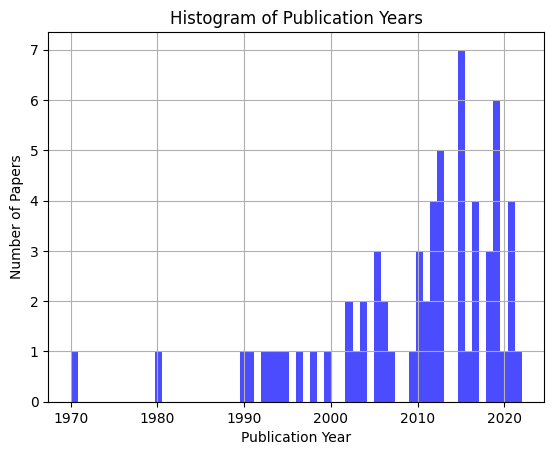

In [66]:
plt.hist(primary_papers['year'], bins=64, color='blue', alpha=0.7)
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.title('Histogram of Publication Years')
plt.grid(True)
plt.show()


Referencia DOI-k számosságának csekkolása:

In [24]:
def count_unique_dois(df, column_name):
    """
    Count the number of unique DOIs in a specified column of a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    column_name (str): The name of the column containing the DOIs.

    Returns:
    int: The count of unique DOIs.
    """

    # Regular expression pattern for matching DOIs
    doi_pattern = r'10.\d{4,9}/[-._;()/:A-Za-z0-9]+'

    # Initialize a set to store unique DOIs
    unique_dois = set()

    # Iterate over each row in the specified column of the DataFrame
    for ref in df[column_name]:
        # Convert to string to handle NaNs or None and other data types
        ref_str = str(ref)

        # Use regular expression to extract DOIs from the string
        found_dois = re.findall(doi_pattern, ref_str)

        # Add the found DOIs to the set (automatically handles uniqueness)
        unique_dois.update(found_dois)

    # Return the total count of unique DOIs
    return len(unique_dois)

In [47]:
unique_doi_count = count_unique_dois(primary_papers, 'reference')
print(f"Total count of unique DOIs: {unique_doi_count}")


Total count of unique DOIs: 640


Új táblát csinálok a primary_papersből, amely a 75 cikk doiját és a referenciák doi-t tartalmazza

In [77]:
new_df = pd.DataFrame({
    'DOI': primary_papers['doi'],
    'References': primary_papers['reference']
})

new_df


DOI  \
0                      10.1016/0022-3913(70)90027-2   
1                  10.1097/00006534-198005000-00009   
2                10.1111/j.1365-2842.1990.tb01427.x   
3   10.1597/1545-1569_1991_028_0285_taosrf_2.3.co_2   
4   10.1597/1545-1569_1992_029_0485_ditrap_2.3.co_2   
..                                              ...   
59                      10.1016/j.ajoms.2020.07.010   
60                   10.1016/j.prosdent.2021.04.009   
61                       10.1186/s40902-021-00315-5   
62                       10.2186/jpr.jpr_d_20_00128   
63                          10.21315/aos2021.16.1.9   

                                           References  
0   10.1016/0022-3913(52)90019-x; 10.1016/0022-391...  
1                                                 NaN  
2   10.1016/0022-3913(72)90198-9; 10.1016/s0022-39...  
3   6948632; 6994933; 10.1016/s0094-1298(20)31649-...  
4   10.1016/0278-2391(84)90008-9; 10.1016/s0300-97...  
..                                                ...  
59  10.1097/00006534-197102000-00010; 10.1001/arch...  
60  10.1007/s00520-011-1105-0; 10.1002/(sici)1097-...  
61  477587; 10.1055/s-0031-1277711; 10.1016/j.coms...  
62  10.1007/s00455-019-10023-y; 10.1152/ajpgi.1989...  
63  10.1097/00000637-200301000-00003; 10.1097/0000...  

[64 rows x 2 columns]

In [78]:
unique_doi_count = count_unique_dois(new_df, 'References')
print(f"Total count of unique DOIs: {unique_doi_count}")


Total count of unique DOIs: 640


# Creating a citing - cited by matrix based on the primary_papers

In [81]:
# Initialize an empty list to store the expanded data
expanded_data = []

# Iterate over each row in the DataFrame
for index, row in primary_papers.iterrows():
    original_doi = row['doi']  # DOI of the original paper

    # Check if 'citation' is a string and not NaN
    if isinstance(row['reference'], str):
        # Use regular expression to extract DOIs from the 'citation' string
        citations = re.findall(doi_pattern, row['reference'])

        # Iterate over each extracted DOI
        for cited_doi in citations:
            expanded_data.append({'Original Paper DOI': original_doi, 'Cited Reference DOI': cited_doi})

# Create a new DataFrame from the expanded data
expanded_df = pd.DataFrame(expanded_data)


expanded_df["Cited Reference DOI"] = expanded_df["Cited Reference DOI"].str.rstrip(';')


# Display the new DataFrame
expanded_df


Original Paper DOI               Cited Reference DOI
0    10.1016/0022-3913(70)90027-2      10.1016/0022-3913(52)90019-x
1    10.1016/0022-3913(70)90027-2      10.1016/0022-3913(64)90187-8
2    10.1016/0022-3913(70)90027-2  10.1097/00006534-196212000-00006
3    10.1016/0022-3913(70)90027-2      10.1016/0022-3913(59)90111-8
4    10.1016/0022-3913(70)90027-2      10.1016/0022-3913(55)90050-0
..                            ...                               ...
929       10.21315/aos2021.16.1.9        10.1016/j.bjps.2007.12.023
930       10.21315/aos2021.16.1.9        10.1001/archotol.134.7.757
931       10.21315/aos2021.16.1.9        10.1001/archotol.134.3.268
932       10.21315/aos2021.16.1.9                 10.1159/000151242
933       10.21315/aos2021.16.1.9      10.1097/scs.0b013e31816ae746

[934 rows x 2 columns]

In [82]:
unique_doi_count = count_unique_dois(expanded_df, 'Cited Reference DOI')
print(f"Total count of unique DOIs: {unique_doi_count}")

Total count of unique DOIs: 625


Ezek után kellene a "Cited Reference DOI"-kat mind megtalálni és a secondary_papers táblát elkészíteni.

In [83]:
doi_pattern = r'10.\d{4,9}/[-._;()/:A-Za-z0-9]+'

# List to store the responses
responses_secondary = []

# Iterate over each row in the DataFrame
for index, row in expanded_df.iterrows():
    # Extract DOIs from the 'Cited Reference DOI' column
    cited_reference_dois = re.findall(doi_pattern, row['Cited Reference DOI'])

    # Iterate through each extracted DOI
    for doi in cited_reference_dois:
        # API call to retrieve metadata
        api_call = f"https://opencitations.net/api/v1/metadata/{doi}"
        http_headers = {"authorization": "739eea95-2ca0-47b1-a11a-84028da7c324"}  # Replace with your actual API key
        response = requests.get(api_call, headers=http_headers)

        # Append the response JSON if the status code is 200, else append None
        if response.status_code == 200:
            responses_secondary.append(response.json())
        else:
            responses_secondary.append(None)

# responses_secondary now contains the metadata for each cited reference DOI


In [84]:
responses_secondary

[[{'source_title': 'The Journal Of Prosthetic Dentistry',
   'source_id': 'issn:0022-3913',
   'title': 'Cleft Palate Prosthesis Rehabilitation',
   'volume': '2',
   'page': '117-135',
   'author': 'Olinger, Nathaniel A.',
   'reference': '10.1016/s0002-9610(36)90436-1; 10.1016/0030-4220(48)90121-2; 10.1016/0096-6347(46)90236-0; 10.1016/0096-6347(46)90237-2; 10.1016/s0096-6347(42)90129-7; 10.1016/0030-4220(49)90304-7; 10.1016/0030-4220(49)90133-4',
   'issue': '1',
   'citation': '10.4047/jkap.2013.51.4.353; 10.1016/b978-0-323-06990-8.00040-3; 10.1016/0030-4220(54)90183-8; 10.1016/0022-3913(53)90154-1; 10.1016/0022-3913(62)90143-9; 10.14219/jada.archive.1959.0033; 10.1016/0022-3913(58)90111-2; 10.1016/0022-3913(70)90027-2',
   'citation_count': '8',
   'year': '1952-01',
   'doi': '10.1016/0022-3913(52)90019-x',
   'oa_link': ''}],
 [{'source_title': 'The Journal Of Prosthetic Dentistry',
   'source_id': 'issn:0022-3913',
   'title': 'Prosthodontics In Cleft Palate Treatment And Resea

In [88]:
secondary_papers = pd.concat([element_to_df(element) for element in responses_secondary], ignore_index=True)
#secondary_papers["author"] = secondary_papers["author"].str.split().str[0].str.rstrip(',') + " et al."
#secondary_papers['year'] = pd.to_datetime(secondary_papers['year'], errors='coerce')
#secondary_papers['year'] = secondary_papers['year'].dt.year
secondary_papers['Primary or Secondary'] = 'Secondary'
#secondary_papers.drop(columns=["key1", "key2", "source_title", "source_id", "volume", "page", "issue", "oa_link"], inplace=True)

#df_unique = secondary_papers.drop_duplicates(subset='doi', keep='first')
#df_unique.to_excel("secondary_papers_raw.xlsx")

In [89]:
#secondary_papers = pd.read_excel("secondary_papers.xlsx")
secondary_papers 

source_title       source_id  \
0                  The Journal Of Prosthetic Dentistry  issn:0022-3913   
1                  The Journal Of Prosthetic Dentistry  issn:0022-3913   
2                     Plastic & Reconstructive Surgery  issn:0032-1052   
3                  The Journal Of Prosthetic Dentistry  issn:0022-3913   
4                  The Journal Of Prosthetic Dentistry  issn:0022-3913   
..                                                 ...             ...   
845  Journal Of Plastic, Reconstructive & Aesthetic...  issn:1748-6815   
846   Archives Of OtolaryngologyâHead & Neck Surgery  issn:0886-4470   
847   Archives Of OtolaryngologyâHead & Neck Surgery  issn:0886-4470   
848                   Folia Phoniatrica Et Logopaedica  issn:1021-7762   
849                    Journal Of Craniofacial Surgery  issn:1536-3732   

                                                 title volume       page  \
0               Cleft Palate Prosthesis Rehabilitation      2    117-135   
1    Prosthodontics In Cleft Palate Treatment And R...     14  1146-1162   
2    Indications And Contraindications For Prosthet...     30    663-669   
3    Velopharyngeal Function And Cleft Palate Prost...      9    149-158   
4    The Prosthetic Management Of Oral And Facial D...      5    413-432   
..                                                 ...    ...        ...   
845  The Modified Honig Velopharyngoplasty â A Ne...     62    646-649   
846  Multicenter Interrater And Intrarater Reliabil...    134        757   
847  Injection Pharyngoplasty With Calcium Hydroxya...    134        268   
848  Speech Outcome Regarding Overall Intelligibili...     60    223-232   
849  Evaluation Of Dynamic Magnetic Resonance Imagi...     19    566-572   

                                                author  \
0                                Olinger, Nathaniel A.   
1                                   Mazaheri, Mohammad   
2                                   Mazaheri, Mohammad   
3                       Aram, Ali; Subtelny, J. Daniel   
4                                  Ackerman, Andrew J.   
..                                                 ...   
845  Mink Van Der Molen, Aebele B.; Janssen, Karlij...   
846  Sie, Kathleen C. Y.; Starr, Jacqueline R, 0000...   
847  Sipp, J. Andrew; Ashland, Jean; Hartnick, Chri...   
848  Van Lierde, Kristiane M.; Bonte, Katrien; Baud...   
849  Atik, Bekir; Bekerecioglu, Mehmet; Tan, Onder;...   

                                             reference issue  \
0    10.1016/s0002-9610(36)90436-1; 10.1016/0030-42...     1   
1    10.1016/0022-3913(62)90142-7; 10.1016/0022-391...     6   
2                                                          6   
3    10.1097/00006534-195701000-00007; 10.1016/s000...     1   
4                                                          3   
..                                                 ...   ...   
845  10.1016/j.bjoms.2004.06.004; 10.1054/jcms.2000...     5   
846  282029; 10.1597/1545-1569_2003_040_0590_trbtco...     7   
847  10.1016/s0194-5998(99)70135-x; 8134487; 10.109...     3   
848  10.1016/s0021-9924(02)00065-5; 10.1016/j.ijpor...     5   
849  6994933; 10.1597/1545-1569_1994_031_0134_lvamt...     3   

                                              citation citation_count  \
0    10.4047/jkap.2013.51.4.353; 10.1016/b978-0-323...              8   
1    10.1007/978-3-642-30770-6_39; 10.7759/cureus.3...              7   
2    10.1590/s1678-77572003000300007; 10.1016/s0011...             22   
3    10.1016/0022-3913(64)90187-8; 10.1111/j.1532-8...             18   
4    10.1186/1757-1626-2-6; 10.1016/0022-3913(86)90...             58   
..                                                 ...            ...   
845  10.1007/s00784-016-1949-2; 10.1097/moo.0b013e3...             14   
846  10.1159/000368005; 10.1177/10556656211025191; ...             33   
847  10.1016/j.ijporl.2009.05.026; 10.1016/j.bjps.2...             39   
848  10.1016/j.jvoice.2015.10.007; 10.21315/

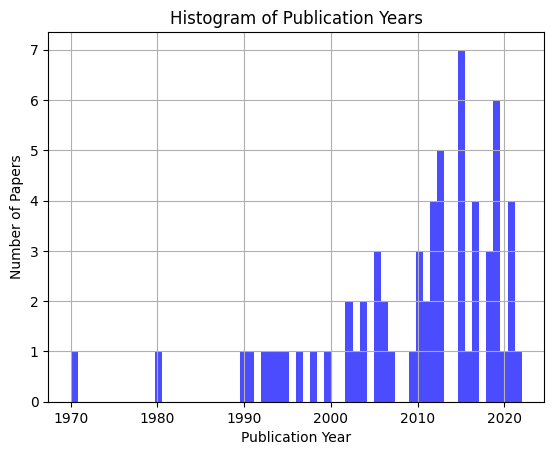

In [91]:
#plt.hist(secondary_papers['year'], bins=64, color='green', alpha=0.7)
plt.hist(primary_papers['year'], bins=64, color='blue', alpha=0.7)
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.title('Histogram of Publication Years')
plt.grid(True)
plt.show()


In [43]:
unique_doi_count = count_unique_dois(secondary_papers, 'doi')
print(f"Total count of unique DOIs: {unique_doi_count}")

Total count of unique DOIs: 633


In [56]:
citation_matrix = pd.crosstab(expanded_df['Original Paper DOI'], expanded_df['Cited Reference DOI'])

In [59]:
coupling_matrix = citation_matrix.dot(citation_matrix.T)


In [60]:
coupling_matrix

Original Paper DOI                                  10.1002/(sici)1097-0347(199709)19:6<524::aid-hed10>3.0.co;2-5  \
Original Paper DOI                                                                                                  
10.1002/(sici)1097-0347(199709)19:6<524::aid-he...                                                 72               
10.1002/hed.10360                                                                                   4               
10.1002/lary.25165                                                                                  0               
10.1002/lary.27240                                                                                  0               
10.1007/s00405-012-2006-7                                                                           2               
10.1016/0022-3913(70)90027-2                                                                        0               
10.1016/j.bjorl.2020.05.028                                                                         0               
10.1016/j.jcomdis.2019.105939                                                                       0               
10.1016/j.jfma.2014.01.013                                                                          0               
10.1016/j.jns.2019.116503                                                                           0               
10.1016/j.prosdent.2003.10.006                                                                      0               
10.1016/j.prosdent.2006.05.004                                                                      1               
10.1016/j.prosdent.2016.10.018                                                                      0               
10.1016/j.prosdent.2021.04.009                                                                      0               
10.1016/s0002-9610(05)80087-x                                                                       0               
10.1016/s0022-3913(96)90449-7                                                                       0               
10.1016/s0278-2391(10)80345-3                                                                      15               
10.1016/s0929-6646(11)60019-3                                                                       0               
10.1016/s1607-551x(08)70013-5                                                                       0               
10.1080/13682820500515852                                                                           0               
10.1097/00000637-200205000-00003                                                                    0               
10.1097/00006534-198005000-00009                                                                    0               
10.1097/scs.0000000000001856                                                                        0               
10.1097/scs.0000000000003167                                                                        0               
10.1097/scs.0000000000003692                                                                        0               
10.1097/scs.0000000000004444                                                                        0               
10.1111/cga.12359                                                                                   0               
10.1111/j.1365-2842.1990.tb01427.x                                                                  0               
10.1111/j.1460-6984.2012.00165.x                                                                    0               
10.1111/j.1532-849x.2009.00545.x                                                                    0               
10.1111/j.1741-2358.2005.00057.x                                                                    0               
10.1111/jopr.12990                                                                                  0               
10.1136/bcr-2013-01010